In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import torch
import torchvision

Inspirations taken from https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition

In [43]:
def one_hot_encoder(label:int, num_labels:int) -> np.ndarray:
    """Takes a numeric label value and returns the corresponding one-hot-encoding vector given the number of labels.
    Labels need to start from zero with step size 1.
    Example: if there are label {0,1,2}, so num_labels=3. Then the method will transform {1} into [0,1,0].
    Example: if there are labels {0,5,9} the method will not work as the labels do not have step size 1 between them.

    Args:
        label (int): label to be transformed into a one-hot-encoding vector
        num_labels (int): number of labels in total

    Returns:
        np.ndarray: one-hot-encoding vector
    """    
    one_hot_vector = np.zeros(num_labels)
    one_hot_vector[label] = 1
    return one_hot_vector

In [44]:
df = pd.read_csv('archive/fer2013/fer2013/fer2013.csv')
num_emotions = df.emotion.value_counts().shape[0]

df_train = df[df['Usage']=='Training'].drop(labels=['Usage'], axis=1)
df_val = df[df['Usage']=='PublicTest'].drop(labels=['Usage'], axis=1)
df_test = df[df['Usage']=='PrivateTest'].drop(labels=['Usage'], axis=1)

X_train = df_train.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_train = np.stack(X_train, axis=0)/255
y_train = df_train.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_train = np.stack(y_train, axis=0)
X_val = df_val.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_val = np.stack(X_val, axis=0)/255
y_val = df_val.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_val = np.stack(y_val, axis=0)
X_test = df_test.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_test = np.stack(X_test, axis=0)/255
y_test = df_test.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_test = np.stack(y_test, axis=0)

print(f'Shape of X_train, y_train: {X_train.shape}, {y_train.shape}')
print(f'Shape of X_val, y_val: {X_val.shape}, {y_val.shape}')
print(f'Shape of X_test, y_test: {X_test.shape}, {y_test.shape}', end='')

Shape of X_train, y_train: (28709, 48, 48, 1), (28709, 7)
Shape of X_val, y_val: (3589, 48, 48, 1), (3589, 7)
Shape of X_test, y_test: (3589, 48, 48, 1), (3589, 7)

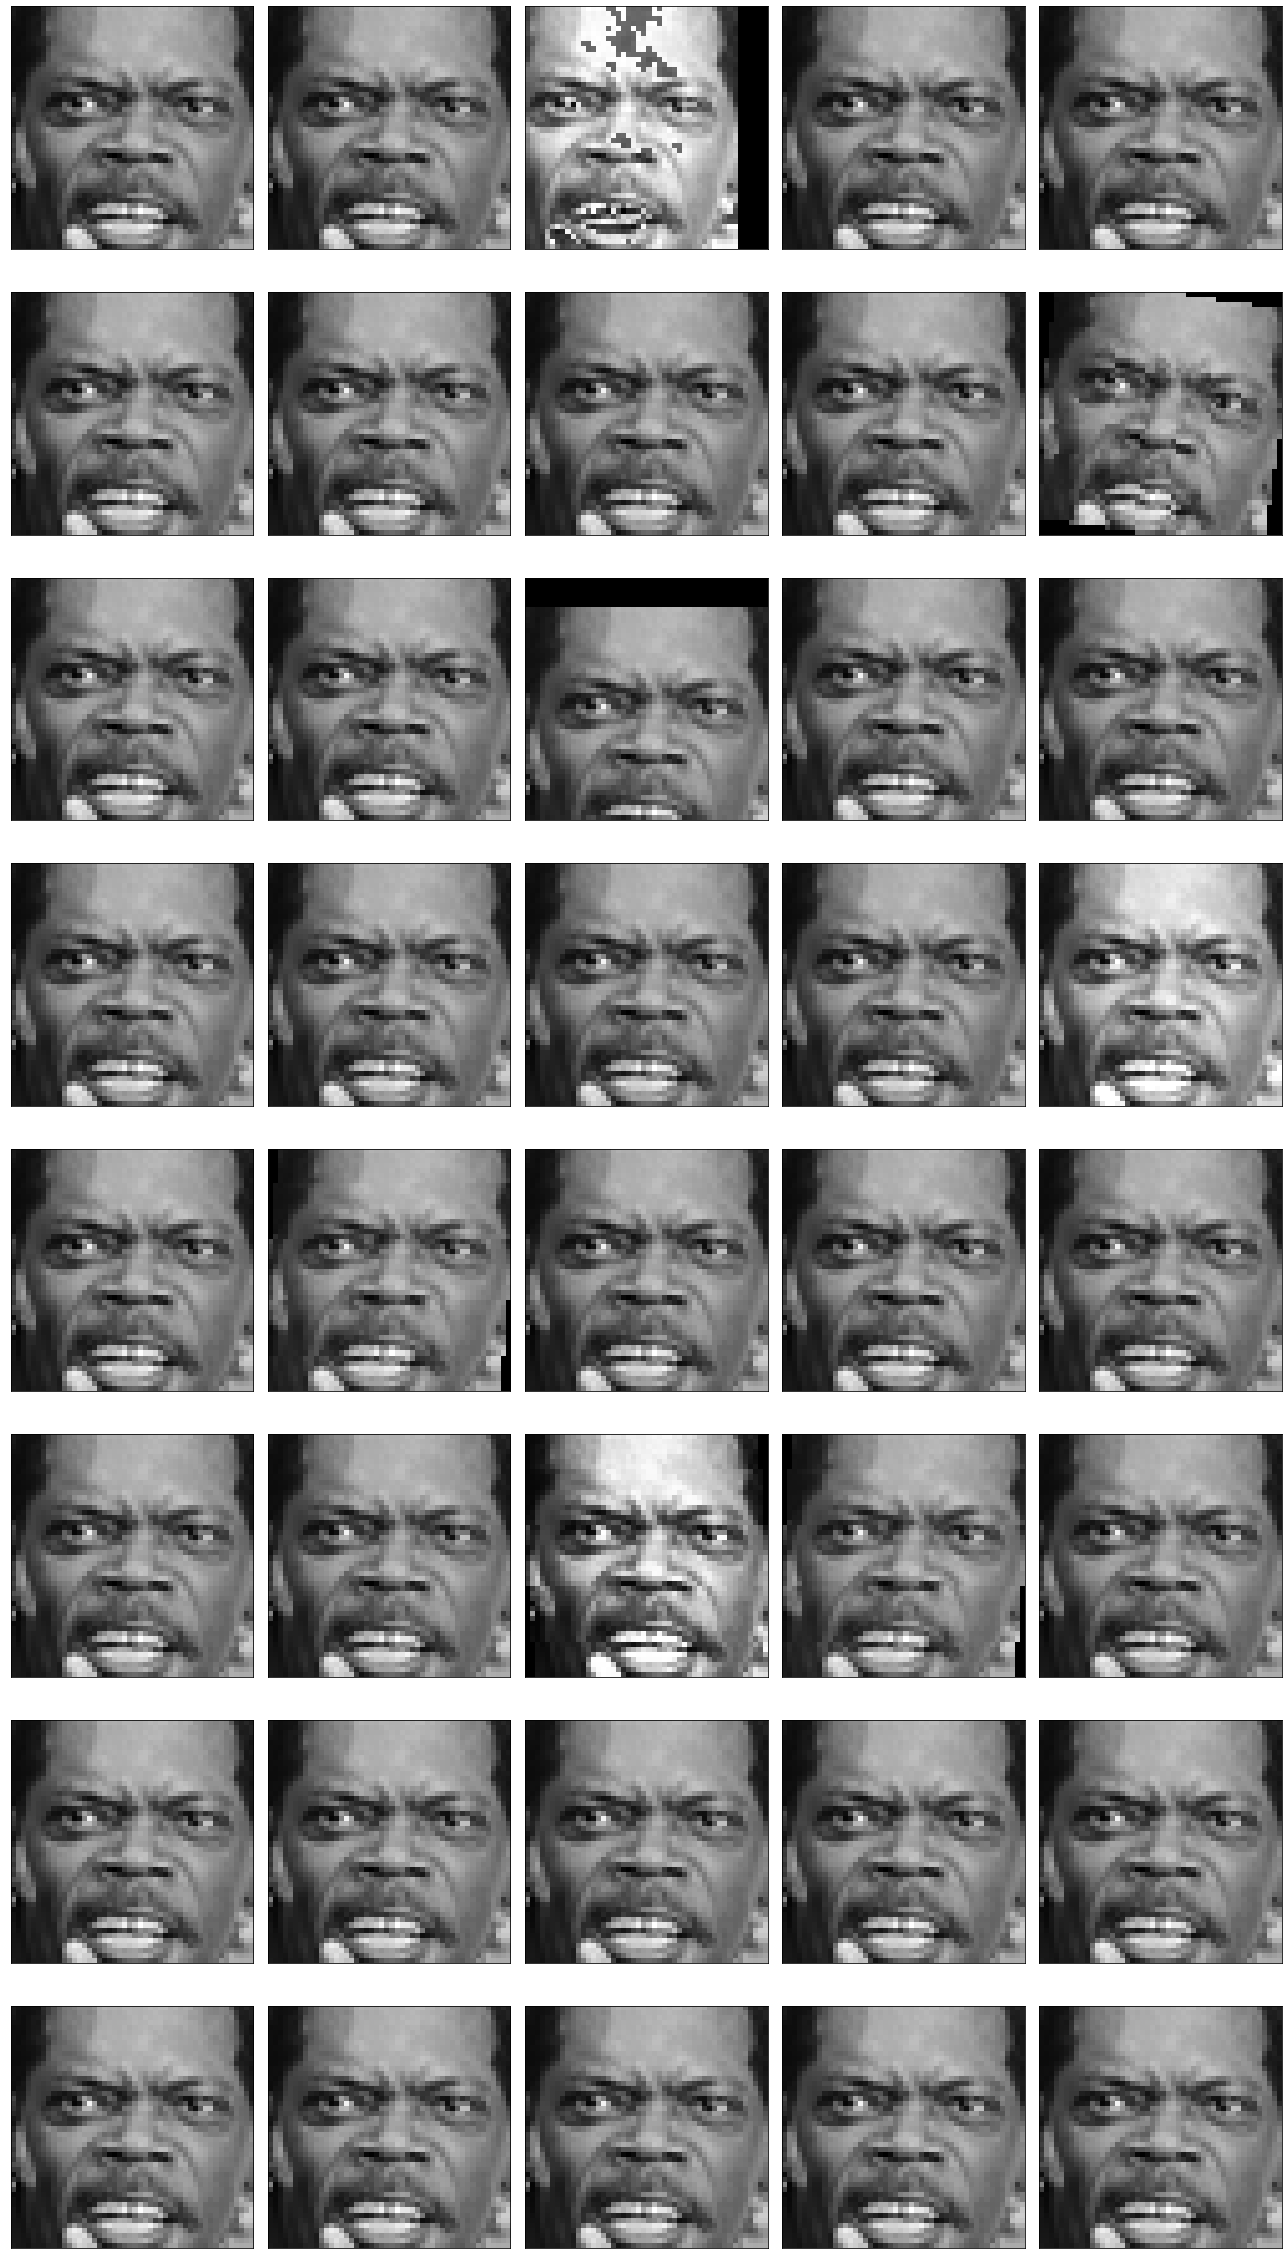

In [45]:
# decided to use the pytorch RandAugment() method as it does exactly what we want
def augment_image(image:np.ndarray):
    prob_for_augmentation = 0.1
    if np.random.random() < prob_for_augmentation:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.ConvertImageDtype(dtype=torch.uint8),
            torchvision.transforms.RandAugment()
        ])
        augmented_image = transform((image*255).astype(np.uint8))
        return np.rollaxis(augmented_image.numpy(), axis=0, start=3)/255
    else: return image

image_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=augment_image)

# testing to see what outputs the augment_image method returns
# on average, one for every (1/prob_for_augmentation) images will be transformed
fig = plt.figure(figsize=(18, 32))
for i in range(40):
    ax = plt.subplot(8, 5, i+1)
    ax.imshow(augment_image(X_train[10]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# alternative ImageDataGenerator function implemented in TensorFlow. 
# I don't like it as much as it does not let you control how many images are augmented. All images are augmented every epoch, which is not what we want I think.
# testing how the augmentations produced by ImageDataGenerator look like
# image_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True, horizontal_flip=True, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, shear_range=10, rescale=1/255.)
# image_augmenter.fit(X_train)
# test = image_augmenter.random_transform(X_train[10])
# plt.imshow(test, cmap='gray')
# print(test.shape)

Emotion encoding:
- 0: anger
- 1: disgust
- 2: fear
- 3: happiness
- 4: sadness
- 5: surprise
- 6: neutral

In [59]:
def create_model(**kwargs) -> tf.keras.Model:
    """creates a keras model which has the architecture pre-specified. 
    The hyperparameters for the model can be passed as keyword arguments and will be used by the model.
    Which parameters can be specified as keyword arguments can be inferred from the "params" dictionary declared in this method.
    In order to adapt for entirely different archtictures, you might want to add further items to the "params" dictionary to allow
    the method to specify the additional (or new) hyper parameters.

    Returns:
        tf.keras.Model: compiled keras model
    """    
    # define default parameter values if not otherwise specified through inputs
    params={'learning_rate': 0.005, 
            'num_convBlocks': 2, 'filters': [16, 32], 'kernel_sizes': [3, 3], 'strides': [(1,1), (1,1)], 'pool_sizes': [(2,2), (2,2)],
            'dense_units': 16, 'dropout': 0}
    for key, value in kwargs.items():
        if key in params:
            params[key] = value

    assert params['num_convBlocks'] >= 1, 'Model needs to have at least one convolutional block to work.'
    assert params['num_convBlocks'] <= 4, 'Specified too many convolutional blocks, will downsample the image too much.'
    assert (params['num_convBlocks'] == len(params['filters'])) & \
            (params['num_convBlocks'] == len(params['kernel_sizes'])) & \
            (params['num_convBlocks'] == len(params['strides'])) & \
            (params['num_convBlocks'] == len(params['pool_sizes'])), 'Specified number of convolutional blocks does not match the number of parameters.'

    model = keras.models.Sequential()

    model.add(keras.layers.Conv2D(filters=params['filters'][0], kernel_size=params['kernel_sizes'][0],
                                    strides=params['strides'][0], activation='relu', padding='same', input_shape=(48,48,1), data_format='channels_last'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=params['pool_sizes'][0], strides=(2,2)))

    for i in range(params['num_convBlocks']-1):
        model.add(keras.layers.Conv2D(filters=params['filters'][i+1], kernel_size=params['kernel_sizes'][i+1], strides=params['strides'][i+1], padding='same', activation='relu'))
        model.add(keras.layers.MaxPool2D(pool_size=params['pool_sizes'][i+1], strides=(2,2)))
        model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=params['dense_units'], activation='relu'))
    # model.add(keras.layers.BatchNormalization())
    # model.add(keras.layers.Dropout(rate=params['dropout']))
    model.add(keras.layers.Dense(units=7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [63]:
# early stopping might need adaptation depending on how the convergence behavior of the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, min_delta=0)

def train_model(epochs:int=100, batch_size:int=64, plot_loss:bool=True, run_on_mac:bool=False, **kwargs):
    """Trains a keras model with architecture specified in the create_model() method.
    Values for hyper parameters that should be used to build the model can be passed as keyword arguments
    or as a dictionary (compare create_model() method to see which ones are available).
    Parameters for the training of the model can be passed directly as inputs to this method.

    Args:
        epochs (int, optional): Maximum number of epochs to train, if early stopping does not cause earlier termination. Defaults to 500.
        batch_size (int, optional): size of a single batch. Defaults to 64.
        plot_loss (bool, optional): whether or not to plot a loss curve at the end of training. Defaults to True.
        run_on_mac (bool, optional): only set to true if you are using a mac and want to utilize its CPU instead of GPU. Defaults to False.

    Returns:
        tf.keras.Model, tf.keras.callbacks.History: returns the trained model and the training history
    """    

    model_params = ['num_convBlocks', 'learning_rate', 'filters', 'kernel_sizes', 'strides', 'pool_sizes', 'dense_units', 'dropout']
    model_kwargs = {}
    for key, value in kwargs.items():
        if key in model_params:
            model_kwargs[key] = value
    
    model = create_model(**model_kwargs)

    image_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=augment_image)
    image_augmenter.fit(X_train)

    if run_on_mac:
        with tf.device('/cpu:0'): # only added this because the code runs quicker on my cpu than on my gpu
            history = model.fit(
                    image_augmenter.flow(X_train, y_train, batch_size=batch_size), 
                    validation_data=(X_val, y_val), 
                    steps_per_epoch=len(X_train)//batch_size,
                    validation_steps = len(X_test)//batch_size, epochs=epochs, 
                    callbacks=[early_stopping], use_multiprocessing=False,
                    batch_size=batch_size
                )
    else:
        history = model.fit(
                image_augmenter.flow(X_train, y_train, batch_size=batch_size), 
                validation_data=(X_val, y_val), 
                steps_per_epoch=len(X_train)//batch_size, 
                validation_steps = len(X_test)//batch_size, epochs=epochs, 
                callbacks=[early_stopping], use_multiprocessing=False,
                batch_size=batch_size
            )

    if plot_loss:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'], '--')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()

    test_accuracy = np.round(model.evaluate(x=X_test, y=y_test, workers=12, use_multiprocessing=False, verbose=0)[1], 6)
    print(f'Accuracy on test set: {test_accuracy}')

    return model, history

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_52 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                     

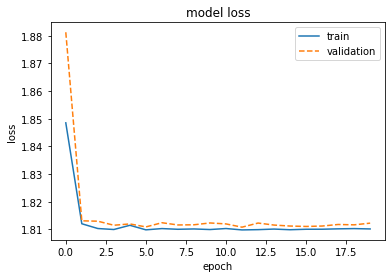

Accuracy on test set: 0.244915


In [62]:
model, history = train_model(epochs=20, run_on_mac=False)

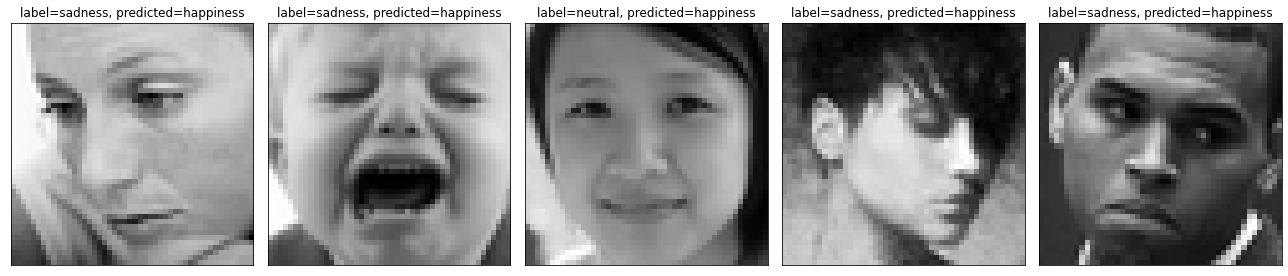

In [64]:
# printing 5 random images with their labels and predictions
emotion_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

predictions = model.predict(X_test, workers=12)
max_predictions = np.argmax(predictions, axis=1)
random_int = np.random.randint(low=0, high=3590-5)

fig = plt.figure(figsize=(18, 5))

for i, prediction in enumerate(max_predictions[random_int:random_int+5]):
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(X_test[random_int+i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'label={emotion_dict[df_test.emotion.iloc[random_int+i]]}, predicted={emotion_dict[prediction]}')
plt.tight_layout()

In [65]:
def test_parameter_values(param_name:str, values:list, semilogx:bool=False, **kwargs) -> dict:
    """Runs the train_model() routine for different values of the specified parameter.

    Args:
        param_name (str): name of the parameter to be tested
        values (list): values to be tested for the parameter
        semilogx (bool, optional): whether to scale the x axis of the plot logarithmically. Defaults to False.

    Returns:
        dict: dictionary containing the name of the tested parameter, the tested values and corresponding accuracy scores on the test set.
    """    

    params={'epochs':500, 'batch_size':64, 'plot_loss':True,
            'learning_rate': 0.005, 
            'num_convBlocks': 2, 'filters': [64, 64], 'kernel_sizes': [3, 3], 'strides': [(1,1), (1,1)], 'pool_sizes': [(3,3), (3,3)],
            'dense_units': 16, 'dropout': 0}

    param_names={'epochs':'epochs', 'batch_size':'batch size', 'plot_loss':True,
            'learning_rate': 'learning rate', 
            'num_convBlocks': '# convolutional blocks (Conv2D, BatchNorm, Pooling)', 'filters': 'filters', 'kernel_sizes': 'kernel sizes', 'strides': 'stride lengths', 'pool_sizes': 'pooling size',
            'dense_units': '# dense units', 'dropout': 'dropout probability'}

    for key, value in kwargs.items():
        if key in params:
            params[key] = value
    
    test_accuracies = []
    for value in values:
        params[param_name] = value
        model, history = train_model(**params)
        test_accuracy = np.round(model.evaluate(x=X_test, y=y_test, workers=12, use_multiprocessing=False, verbose=0)[1], 6)   
        test_accuracies.append(test_accuracy)
        
    figure = plt.figure(figsize=(8,12))
    plt.plot(values, test_accuracies)
    if semilogx:
        plt.semilogx()
    plt.title(str(f'Validation Accuracy of different values for {param_name}'))
    plt.xlabel(param_names[param_name])
    plt.ylabel("Validation Accuracy Score")

    return {'parameter name': param_name, 'values':values, 'val_accuracies':test_accuracies}

In [66]:
def test_model_specifications(parameter_dicts:dict) -> list:
    
    test_accuracies = []
    for params in parameter_dicts:
        model, history = train_model(**params)
        test_accuracy = np.round(model.evaluate(x=X_test, y=y_test, workers=12, use_multiprocessing=False, verbose=0)[1], 6)   
        test_accuracies.append(test_accuracy)
        
    return test_accuracies


def plot_accuracy_for_parameter(param_name:str, values:list, parameter_dicts:dict, semilogx:bool=False) -> list:
    test_accuracies = test_model_specifications(parameter_dicts)

    param_names={'epochs':'epochs', 'batch_size':'batch size', 'plot_loss':True,
        'learning_rate': 'learning rate', 
        'num_convBlocks': '# convolutional blocks (Conv2D, BatchNorm, Pooling)', 'filters': 'filters', 'kernel_sizes': 'kernel sizes', 'strides': 'stride lengths', 'pool_sizes': 'pooling size',
        'dense_units': '# dense units', 'dropout': 'dropout probability'}

    figure = plt.figure(figsize=(8,12))
    plt.plot(values, test_accuracies)
    if semilogx:
        plt.semilogx()
    plt.title(str(f'Test Accuracy of different values for {param_names[param_name]}'))
    plt.xlabel(param_names[param_name])
    plt.ylabel("Test Accuracy Score")

    return {'parameter name': param_name, 'values':values, 'val_accuracies':test_accuracies}

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_67 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 9216)              0         
                                                                 
 dense_50 (Dense)            (None, 16)                147472    
                                                                 
 dense_51 (Dense)            (None, 7)               

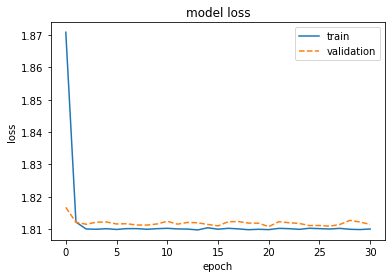

Accuracy on test set: 0.244915
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_68 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                      

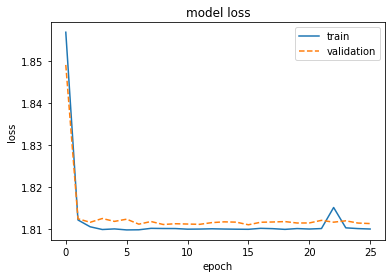

Accuracy on test set: 0.244915
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_70 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                      

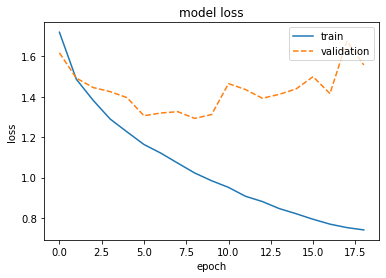

Accuracy on test set: 0.515464
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_73 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                      

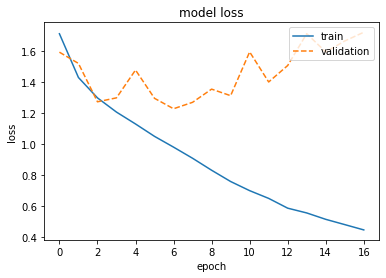

Accuracy on test set: 0.554751


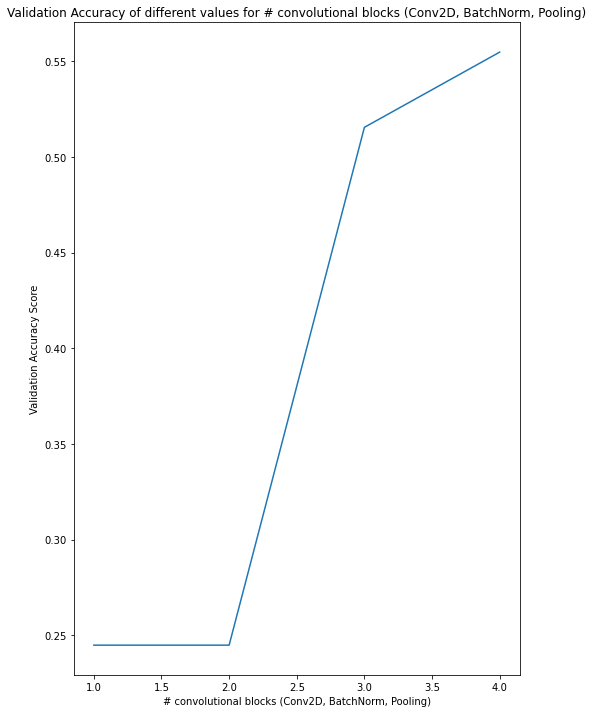

In [70]:
params=[{'learning_rate': 0.005, 
        'num_convBlocks': 1, 'filters': [16], 'kernel_sizes': [3], 'strides': [(1,1)], 'pool_sizes': [(2,2)],
        'dense_units': 16, 'dropout': 0},
        {'learning_rate': 0.005, 
        'num_convBlocks': 2, 'filters': [16, 32], 'kernel_sizes': [3]*2, 'strides': [(1,1)]*2, 'pool_sizes': [(2,2)]*2,
        'dense_units': 16, 'dropout': 0},
        {'learning_rate': 0.005, 
        'num_convBlocks': 3, 'filters': [16, 32, 64], 'kernel_sizes': [3]*3, 'strides': [(1,1)]*3, 'pool_sizes': [(2,2)]*3,
        'dense_units': 16, 'dropout': 0},
        {'learning_rate': 0.005, 
        'num_convBlocks': 4, 'filters': [16, 32, 64, 128], 'kernel_sizes': [3]*4, 'strides': [(1,1)]*4, 'pool_sizes': [(2,2)]*4,
        'dense_units': 16, 'dropout': 0},
        ]

results_dict = plot_accuracy_for_parameter(param_name='num_convBlocks', values=[1,2,3,4], parameter_dicts=params)

In [71]:
print(results_dict)

{'parameter name': 'num_convBlocks', 'values': [1, 2, 3, 4], 'val_accuracies': [0.244915, 0.244915, 0.515464, 0.554751]}
